In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [ ]:
df =pd.read_csv(csv_path)
df = df[5::6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [ ]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


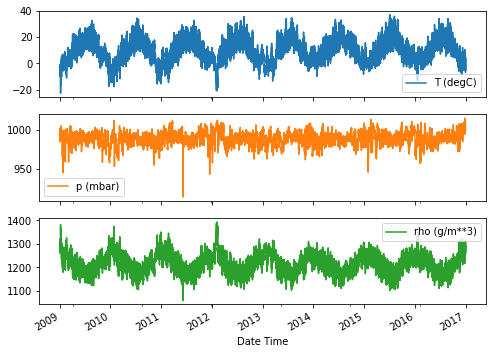

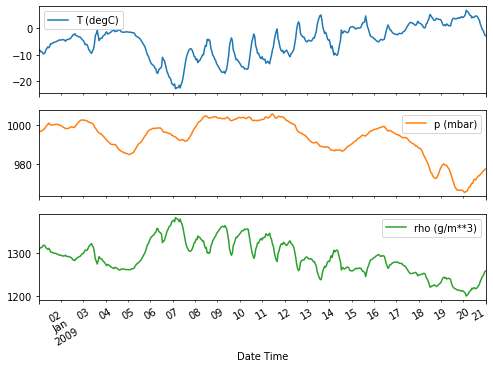

In [ ]:
plot_cols=['T (degC)','p (mbar)', 'rho (g/m**3)']
plot_features=df[plot_cols]
plot_features.index=date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [ ]:
wv= df['wv (m/s)']
bad_wv = wv==-9999.0
wv[bad_wv]=0

max_wv = df['max. wv (m/s)']
bad_max_wv= max_wv==-9999.0
max_wv[bad_max_wv]=0

df['wv (m/s)'].min()

0.0

feature engineering 
 
1. 바람 
- wd(deg)는 도 단위로 바람의 방향을 나타냄. 각도 가 있으면 모델 입력으로 좋지 않으므로 360도와 0도는 서로 가까워야 하며 부드럽게 휘어져야 함.
- 바람이 불지 않으면 방향은 중요하지 않음

Text(0, 0.5, 'wind velocity [m/s]')

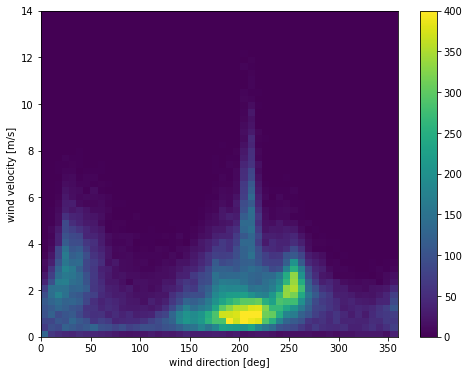

In [ ]:
#바람의 데이터 분포 
plt.hist2d(df['wd (deg)'],df['wv (m/s)'], bins= (50,50), vmax=400)
plt.colorbar()
plt.xlabel('wind direction [deg]')
plt.ylabel('wind velocity [m/s]')

In [ ]:
# 풍향과 속도 열을 바람 벹거로 변환하면 모델을 해석하기가 쉬워짐
wv =df.pop('wv (m/s)')
max_wv =df.pop('max. wv (m/s)')
wd_rad= df.pop('wd (deg)')*np.pi/180
df['Wx']=wv*np.cos(wd_rad)
df['Wy']=wv*np.sin(wd_rad)

df['max Wx']=max_wv*np.cos(wd_rad)
df['max Wy']=max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

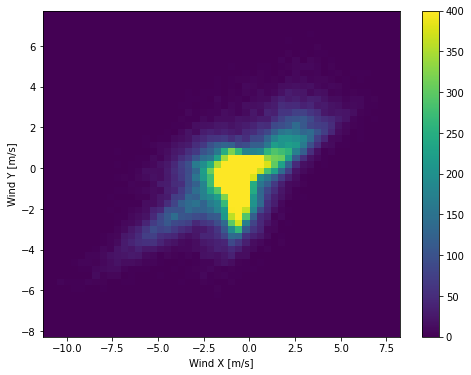

In [ ]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50,50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax= plt.gca()
ax.axis('tight')

2. 시간 
- 초 단위의 시간은 유용한 모델 입력이 아님. 날씨 데이터 이므로 하루 및 연 단위의 주기성이 명확하다. 
- 삼각함수를 이용하여 시간을 명확한 하루 중 시간 및 연중 시간 신호로 변환할 수 있다. 

In [ ]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [ ]:
timestamp_s

5         1.230772e+09
11        1.230775e+09
17        1.230779e+09
23        1.230782e+09
29        1.230786e+09
              ...     
420521    1.483211e+09
420527    1.483215e+09
420533    1.483219e+09
420539    1.483222e+09
420545    1.483226e+09
Name: Date Time, Length: 70091, dtype: float64

In [ ]:
day =24*60*60
year= 365.2425*day
df['Day sin']=np.sin(timestamp_s*(2*np.pi/day))
df['Day cos']=np.cos(timestamp_s*(2*np.pi/day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

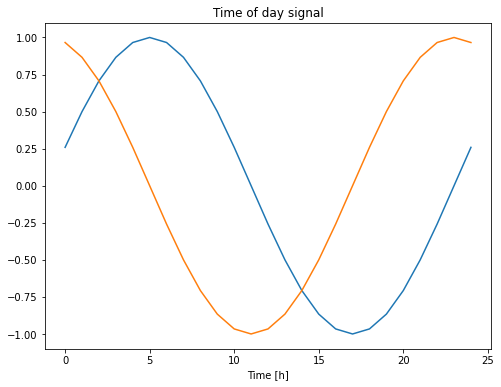

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

- 모델이 가장 중요한 빈도 특성에 엑세스할 수 있음 
- fft를 사용하여 중요한 빈도를 결정할 수 있음

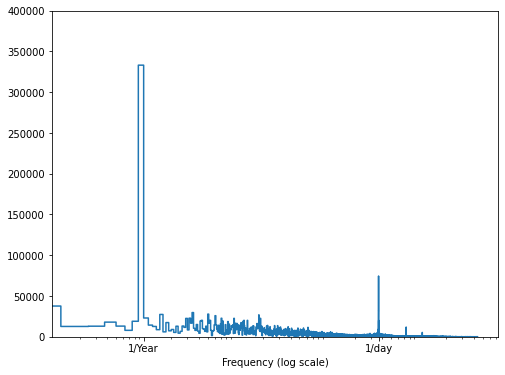

In [ ]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

데이터 분할 

In [ ]:
columns_indices= {name: i for i, name in enumerate(df.columns)}
n=len(df)
train_df= df[0:int(n*0.7)]
val_df= df[int(n*0.7):int(n*0.9)]
test_df= df[int(n*0.9):]
num_features= df.shape[1]

데이터 정규화

In [ ]:
train_mean = train_df.mean()
train_std= train_df.std()

In [ ]:
train_mean

p (mbar)            988.656343
T (degC)              9.108207
Tpot (K)            283.194958
Tdew (degC)           4.599605
rh (%)               75.906008
VPmax (mbar)         13.355098
VPact (mbar)          9.356960
VPdef (mbar)          3.998056
sh (g/kg)             5.913550
H2OC (mmol/mol)       9.466371
rho (g/m**3)       1216.994357
Wx                   -0.594182
Wy                   -0.391513
max Wx               -0.962159
max Wy               -0.709401
Day sin              -0.000054
Day cos              -0.000072
Year sin              0.052824
Year cos             -0.016243
dtype: float64

In [ ]:
train_df= (train_df-train_mean)/train_std
val_df= (val_df-train_mean)/train_std
test_df =(test_df-train_mean)/train_std

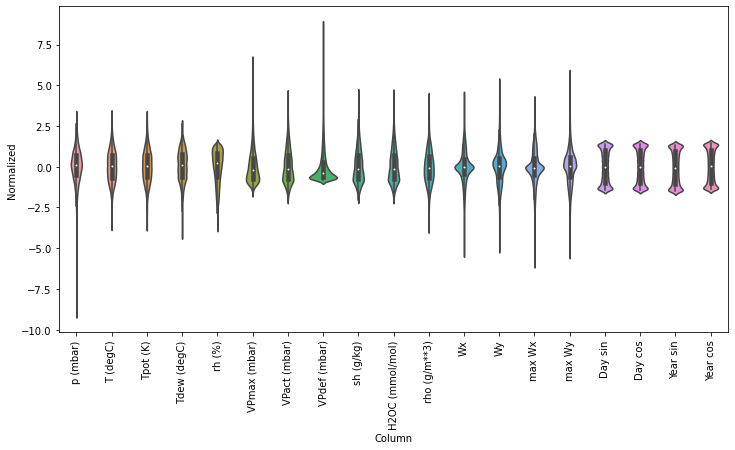

In [ ]:
df_std= (df-train_mean)/train_std
df_std= df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12,6))
ax= sns.violinplot(x='Column', y='Normalized', data= df_std)
_= ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, train_df= train_df, val_df= val_df, test_df= test_df, label_columns=None):
    self.train_df =train_df
    self.val_df= val_df
    self.test_df= test_df

    self.label_columns=label_columns
    if label_columns is not None:
      self.label_columns_indices= {name: i for i, name in enumerate(label_columns)}
    self.column_indices ={name: i for i, name in enumerate(train_df.columns)}

    self.input_width = input_width
    self.label_width = label_width
    self.shift= shift

    self.total_window_size= input_width+shift

    self.input_slice = slice(0, input_width)
    self.input_indices= np.arange(self.total_window_size)[self.input_slice]
    self.label_start = self.total_window_size-self.label_width
    self.labels_slice= slice(self.label_start , None) #slice: slicing 을 수행할 범위를 저장하는 객체 
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice] #slice 객체를 통해 slicing 수행
  def __repr__(self):
    return '\n'.join([
      f'Total window size:{self.total_window_size}',
      f'Input indices:{self.input_indices}', 
      f'Label indices:{self.label_indices}',
      f'Label column name(s):{self.label_columns}'
    ])


In [ ]:
w1= WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['T (degC)'])
w1

Total window size:48
Input indices:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices:[47]
Label column name(s):['T (degC)']

In [ ]:
w2= WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['T (degC)'])
w2

Total window size:7
Input indices:[0 1 2 3 4 5]
Label indices:[6]
Label column name(s):['T (degC)']

In [ ]:
def split_window(self, features):
  inputs= features[:, self.input_slice,:]
  labels= features[:, self.labels_slice,:]
  if self.label_columns is not None:
    labels= tf.stack([labels[:,:, self.column_indices[name]]for name in self.label_columns], axis=-1)
  # 슬라이싱은 static shape information 을 보존하지 않기 때문에 shape을 새로 지정해줘야함
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels
WindowGenerator.split_window= split_window

In [ ]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example 
  plt.figure(figsize=(12,8))
  plot_col_index= self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3,1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index], label= 'Inputs', marker= '.', zorder=-10)
    if self.label_columns:
      label_col_index= self.label_columns_indices.get(plot_col, None)
    else: 
      label_col_index= plot_col_index
    if label_col_index is None:
      continue
    plt.scatter(self.label_indices, labels[n,:, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label ='Predictions', c='#ff7f0e', s=64)
    if n==0:
      plt.legend()
  plt.xlabel('Time [h]')
WindowGenerator.plot=plot

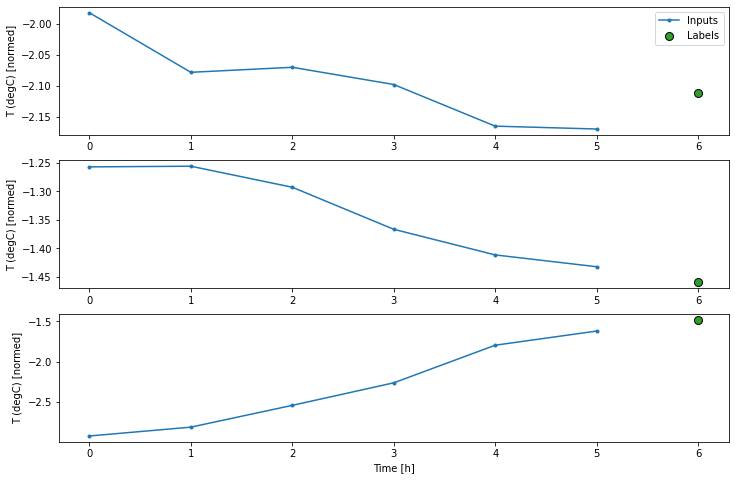

In [ ]:
w2.plot()

In [ ]:
def make_dataset(self, data):
  data= np.array(data, dtype= np.float32)
  ds= tf.keras.preprocessing.timeseries_dataset_from_array(
      data= data, 
      targets=None, 
      sequence_length= self.total_window_size, 
      sequence_stride= 1, 
      shuffle= True, 
      batch_size= 32, 
  )
  ds= ds.map(self.split_window)
  return ds
WindowGenerator.make_dataset=make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


단일 스텝 모델 
- 현재 조건에만 기초하여 미래로 1타임스텝 진행된 단일 특성값을 예측하는 모델

In [ ]:
single_step_window= WindowGenerator( input_width=1, label_width=1, shift=1, label_columns=['T (degC)'])
single_step_window

Total window size:2
Input indices:[0]
Label indices:[1]
Label column name(s):['T (degC)']

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


baseline model 
- 모든 특성의 현재 값을 고려하여 1시간 미래의 온도를 예측하는 것 
- 예측으로 현재 온도를 반환하여 '변화없음'을 예측하는 모델로 baseline 설정

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index= None):
    super().__init__()
    self.label_index= label_index
  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline =Baseline(label_index=columns_indices['T (degC)'])

baseline.compile(loss= tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

val_performance= {}
performance={}
val_performance['Baseline']=baseline.evaluate(single_step_window.val)
performance['Baseline']=baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 3ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


In [ ]:
wide_window= WindowGenerator(
    input_width=24, label_width= 24, shift=1, label_columns=['T (degC)'])
wide_window

Total window size:25
Input indices:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices:[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s):['T (degC)']

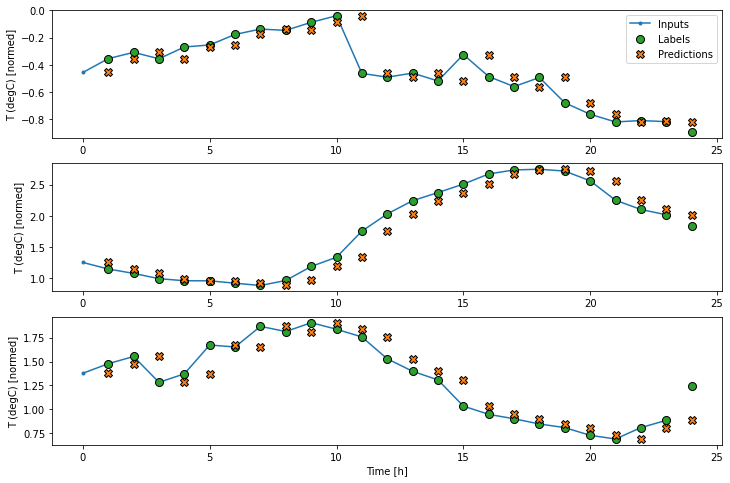

In [ ]:
wide_window.plot(baseline)

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
MAX_EPOCHS= 20 
def compile_and_fit(model, window, patience= 2):
  early_stopping =tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
  model.compile(loss=tf.losses.MeanSquaredError(), optimizer= tf.optimizers.Adam(), metrics= [tf.metrics.MeanAbsoluteError()])
  history= model.fit(window.train, epochs=MAX_EPOCHS, validation_data= window.val, callbacks=[early_stopping])
  return history

In [ ]:
history= compile_and_fit(linear, single_step_window)
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0959 - mean_absolute_error: 0.1862 - val_loss: 0.0177 - val_mean_absolute_error: 0.0977
Epoch 2/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0144 - mean_absolute_error: 0.0886 - val_loss: 0.0109 - val_mean_absolute_error: 0.0772
Epoch 3/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0109 - mean_absolute_error: 0.0773 - val_loss: 0.0101 - val_mean_absolute_error: 0.0741
Epoch 4/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0104 - mean_absolute_error: 0.0753 - val_loss: 0.0097 - val_mean_absolute_error: 0.0728
Epoch 5/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0101 - mean_absolute_error: 0.0741 - val_loss: 0.0095 - val_mean_absolute_error: 0.0720
Epoch 6/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0099 - mean_absolute_error: 0.0732 - val_loss: 0.0093 - val_mean_absolute_error: 0.0714
Epoc

In [ ]:
dense= tf.keras.Sequential(
    [
     tf.keras.layers.Dense(units=64, activation='relu'), 
     tf.keras.layers.Dense(units=64, activation='relu'),
     tf.keras.layers.Dense(units=1)
    ]
)
history= compile_and_fit(dense, single_step_window)
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0169 - mean_absolute_error: 0.0803 - val_loss: 0.0092 - val_mean_absolute_error: 0.0713
Epoch 2/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0079 - mean_absolute_error: 0.0642 - val_loss: 0.0076 - val_mean_absolute_error: 0.0645
Epoch 3/20
1534/1534 [==============================] - 8s 6ms/step - loss: 0.0075 - mean_absolute_error: 0.0624 - val_loss: 0.0072 - val_mean_absolute_error: 0.0619
Epoch 4/20
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0072 - mean_absolute_error: 0.0609 - val_loss: 0.0067 - val_mean_absolute_error: 0.0583
Epoch 5/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0071 - mean_absolute_error: 0.0603 - val_loss: 0.0068 - val_mean_absolute_error: 0.0596
Epoch 6/20
439/439 [==============================] - 1s 3ms/step - loss: 0.0088 - mean_absolute_error: 0.0688


In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size:4
Input indices:[0 1 2]
Label indices:[3]
Label column name(s):['T (degC)']

In [ ]:
multi_step_dense= tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1), 
    tf.keras.layers.Reshape([1,-1]) #(1, outputs) => 맨 처음에 flatten으로 펴줬기 때문에 다시 변환할 필요가 있음
    ])

In [ ]:
history= compile_and_fit(multi_step_dense, conv_window)

Epoch 1/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0255 - mean_absolute_error: 0.1043 - val_loss: 0.0096 - val_mean_absolute_error: 0.0732
Epoch 2/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0086 - mean_absolute_error: 0.0684 - val_loss: 0.0077 - val_mean_absolute_error: 0.0642
Epoch 3/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0078 - mean_absolute_error: 0.0633 - val_loss: 0.0074 - val_mean_absolute_error: 0.0624
Epoch 4/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0075 - mean_absolute_error: 0.0620 - val_loss: 0.0073 - val_mean_absolute_error: 0.0631
Epoch 5/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0071 - mean_absolute_error: 0.0601 - val_loss: 0.0069 - val_mean_absolute_error: 0.0596
Epoch 6/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0590 - val_loss: 0.0064 - val_mean_absolute_error: 0.0565
Epoc

RNN: 시계열 데이터 분석에 용이함

- return_sequences= True: 레이어가 각 입력에 대한 출력을 반환, rnn 레이어를 쌓거나 여러 타임스텝에서 동시에 모델을 훈련할 때 유용함

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True), #shape : (batch, time, features) -> (batch, time, lstm_units)
    tf.keras.layers.Dense(1) #shape: (batch, time, features)
])

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 2s 5ms/step - loss: 0.0056 - mean_absolute_error: 0.0517


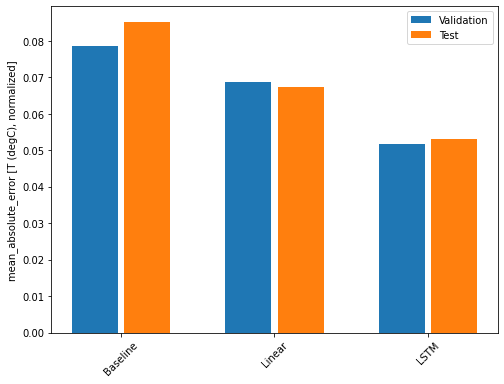

In [ ]:
x= np.arange(len(performance))
width = 0.3
metric_name= 'mean_absolute_error'
metric_index= lstm_model.metrics_names.index('mean_absolute_error')
val_mae= [v[metric_index] for v in val_performance.values()]
test_mae= [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x-0.17, val_mae,width, label='Validation')
plt.bar(x+0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_=plt.legend()

다중 출력 모델

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)


In [ ]:
baseline= Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance= {}
test_performance={}
val_performance['Baseline']= baseline.evaluate(wide_window.val)
test_performance['Baseline']= baseline.evaluate(wide_window.test)

219/219 [==============================] - 1s 3ms/step - loss: 0.0903 - mean_absolute_error: 0.1638


In [ ]:
dense= tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(num_features)
])

history= compile_and_fit(dense, single_step_window)
IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 3ms/step - loss: 0.0673 - mean_absolute_error: 0.1300


In [ ]:
%%time
wide_window= WindowGenerator(
    input_width=24, label_width = 24, shift= 1)
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True), 
    tf.keras.layers.Dense(num_features)
])
history= compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)
print()

438/438 [==============================] - 2s 5ms/step - loss: 0.0614 - mean_absolute_error: 0.1196

CPU times: user 6min 35s, sys: 37.5 s, total: 7min 13s
Wall time: 4min 19s


잔여 연결 

- 위의 baseline 모델은 시퀀스가 타임스텝 사이에서 크게 변하지 않는다는 사실을 이용하였음 
- 시계열 분석에서는 다음 값을 예측하는 대신 다음 타임스텝에서 값이 어떻게 달라지는 지를 예측하는 모델을 빌드하는 것이 일반적이다. 
- 딥러닝에서 ResNets 는 각 레이어가 모델의 누적 결과에 추가되는 아키텍처를 나타냄 

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model 
  def call(self, inputs, *args, **kwargs):
    delta= self.model(inputs, *args, *kwargs)

    # 매 타입스텝의 예측값은 모델에 의해 계산된 delta 와 이전 타임스텝의 input의 합
    return inputs+delta

In [ ]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
      tf.keras.layers.LSTM(32, return_sequences=True), 
      tf.keras.layers.Dense(num_features, kernel_initializer=tf.initializers.zeros)
    ])
)
history= compile_and_fit(residual_lstm, wide_window)
IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

438/438 [==============================] - 2s 5ms/step - loss: 0.0619 - mean_absolute_error: 0.1181



In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

다중 스텝 모델 

- 앞선 단일 출력 및 다중 출력 모델은 모두 미래 1시간의 단일 타임스텝 예측을 수행 
- 모델을 확장하여 다중 타임스텝 예측을 수행: 미래 값의 시퀀스를 예측함 
- 전체 시계열이 한 번에 예측되는 싱글샷 예측 
- 모델이 단일 스텝 예측만 수행하고 출력이 입력으로 피드백되는 자기 회귀적 예측 

Total window size:48
Input indices:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices:[24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s):None

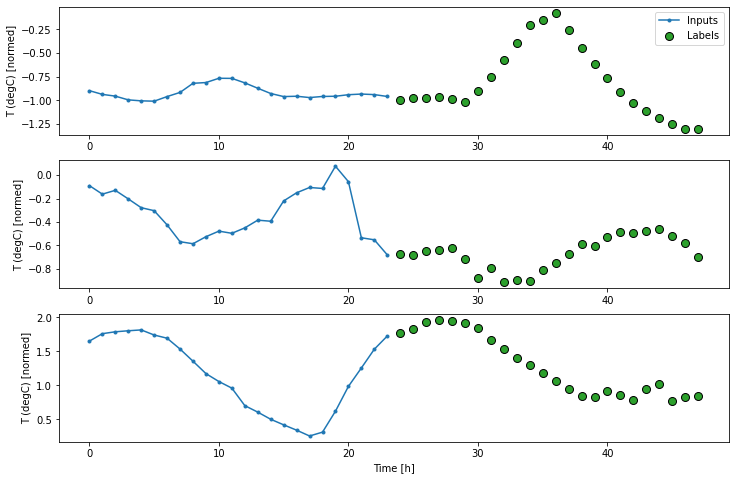

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

아이디어: 필요한 출력 타임스텝 수에 대해 마지막 입력 타입스텝을 반복함

437/437 [==============================] - 1s 3ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


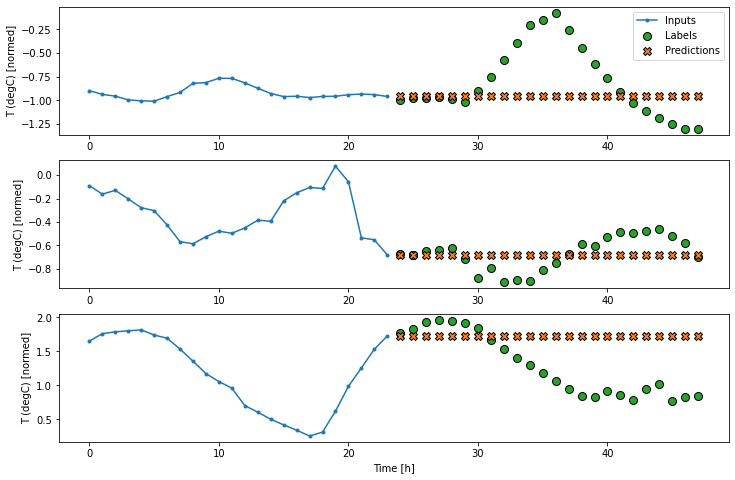

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])
last_baseline= MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(), metrics= [tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

아이디어: 내일도 비슷하다는 가정하에 전날을 반복하는 것 

437/437 [==============================] - 1s 3ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


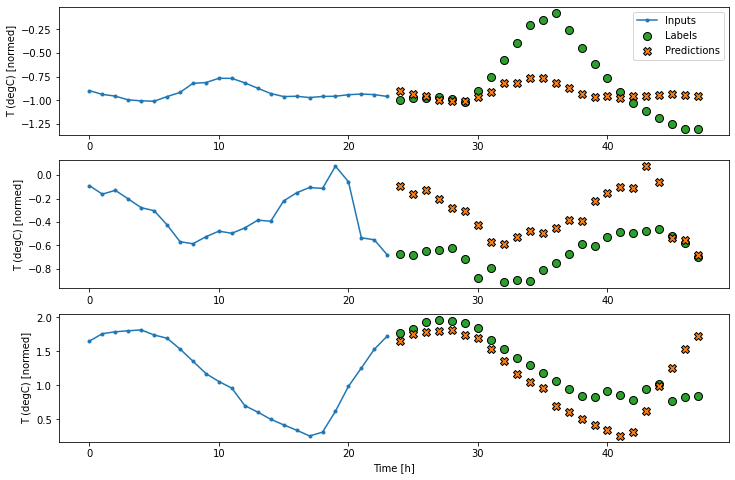

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline= RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(), metrics = [tf.metrics.MeanAbsoluteError()])
multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

싱글샷 모델 

- out_steps * features 출력 단위를 이용해 fc network 로 구현 
- output_shape: (output_steps, features)

437/437 [==============================] - 1s 3ms/step - loss: 0.2557 - mean_absolute_error: 0.3049


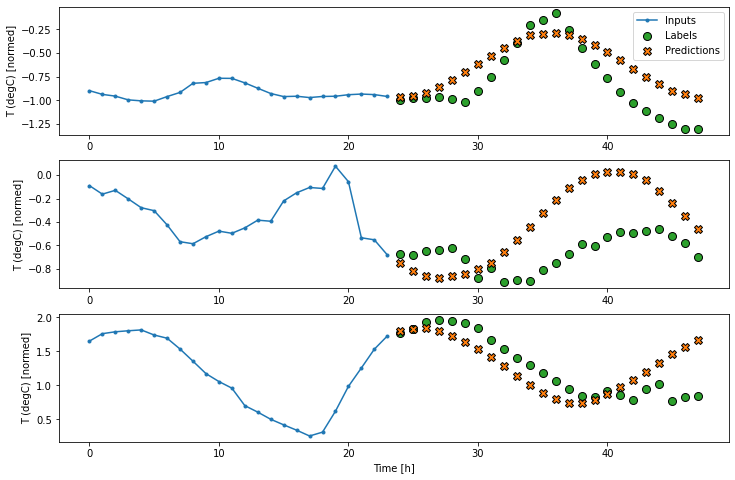

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]), # 마지막 입력 값만 출력 시퀀스를 예측하는데 사용하였음
    # Shape => [batch, 1, out_steps*features]
    # 여기서 fc network를 추가하여 성능을 높일 수 있으나, 다이나믹하게 개선되진 않음, 다른 아키텍처를 도입하는 것을 추천함
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

CNN

- 고정 너비 기록을 기반으로 예측을 수행하므로 시간에 따라 상황이 어떻게 변하는지 볼 수 잇어 밀집 모델보다 성능을 높일 수 있음 

437/437 [==============================] - 2s 4ms/step - loss: 0.2146 - mean_absolute_error: 0.2826


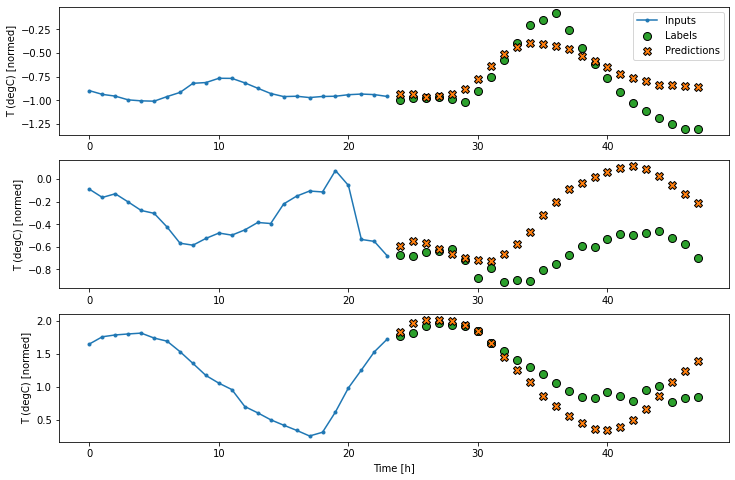

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

RNN

- 반복 모델은 모델이 수행하는 예측과 관련이 있는 경우 긴 입력 기록을 사용하는 방법을 학습할 수 있음. 
- 여기서 모델은 다음 24시간에 대한 단일 예측을 수행하기 전에 24시간 동안 내부 상태를 축적함

437/437 [==============================] - 2s 5ms/step - loss: 0.2146 - mean_absolute_error: 0.2854


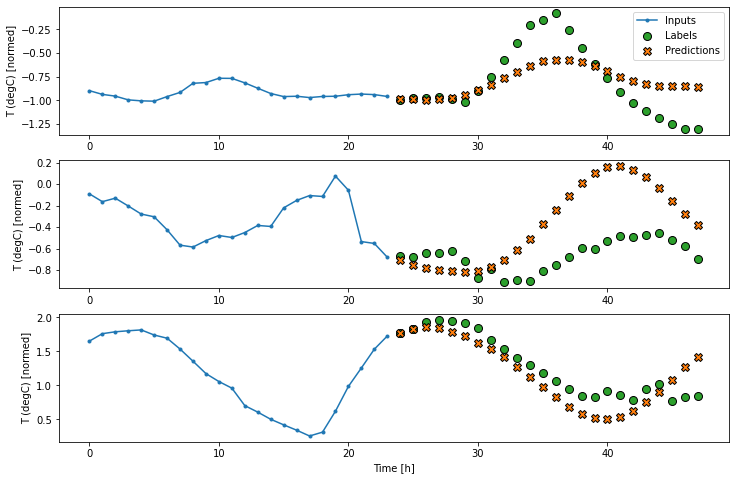

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

자기 회귀 모델 
 
- 모델이 예측을 여러 타임스텝으로 분해하는 것이 도움이 될 때가 있음 
- 각 모델의 출력을 각 스텝에서 자체 피드백을 할 수 있어 이전 예측을 조건부로 예측을 수행할 수 있음 
- 다양한 길이의 출력을 생성하도록 저장할 수 있다. 

- layers.LSTM은 상태와 시퀀스 결과를 자동으로 관리하는 더 높은 수준의 layers.RNN에서 래핑된 layers.LSTMCell 이다. 
- 각 스텝에 대한 입력을 수동으로 관리해야 하므로 더 낮은 수준의 단일 타임스텝 인터페이스에 대해 layers.LSTMCell을 직접 사용한다. 

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps= out_steps
    self.units=units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    self.lstm_rnn= tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense=tf.keras.layers.Dense(num_features)
  def warmup(self, inputs):
    x, *state= self.lstm_rnn(inputs)
    prediction= self.dense(x)
    return prediction, state
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

In [ ]:
def call(self, inputs, training=None):
  predictions=[]
  prediction, state= self.warmup(inputs)
  predictions.append(prediction)

  for n in range(1, self.out_steps):
    x=prediction
    x, state= self.lstm_cell(x, states= state, training=training)
    predicition =self.dense(x)
    predictions.append(prediction)
  predictions= tf.stack(predictions)
  predictions= tf.transpose(predictions, [1,0,2])
  return predictions

FeedBack.call = call